In [1]:
#!pip install celery

In [2]:
!sudo rabbitmqctl add_user myguest myguestpwd
!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

Creating user "myguest" ...
Error: user_already_exists: myguest
Setting permissions for user "myguest" in vhost "/" ...


**The below code will use 4 workers**

Run this, e,g with: <br>
<code> celery -A linear_regression_workers worker --loglevel=info --concurrency=4 </code>

In [3]:
!sudo rabbitmqctl list_users

Listing users ...
guest	[administrator]
myguest	[]


In [4]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.datasets import make_blobs
from copy import deepcopy

from celery import group
from linear_regression_workers import lin_regression_tasks, calc_A, solve_lin_regession, NumpyEncoder


### Creating a dataset

In [5]:
def gen_data(n,a,b,mu_x,sigma_x,sigma_e):
    x= np.random.normal(mu_x,sigma_x,[n,1])
    e= np.random.normal(0,sigma_e,[n,1])
    y  = a*x+b+e
    return x,y

n1=200
x1,y1 = gen_data(n=n1,a=-1,b=3,mu_x=-1,sigma_x=2,sigma_e=1)

n2=200
x2,y2 = gen_data(n=n2,a=-0.7,b=13,mu_x=5,sigma_x=2,sigma_e=1)

n3=200
x3,y3 = gen_data(n=n3,a=-1.7,b=27,mu_x=8,sigma_x=2,sigma_e=0.5)

n4=200
x4,y4 = gen_data(n=n3,a=-1.9,b=-5,mu_x=-5,sigma_x=1.5,sigma_e=0.5)


In [6]:
XY=[[x1,y1],[x2,y2],[x3,y3],[x4,y4]]

### Show the Dataset

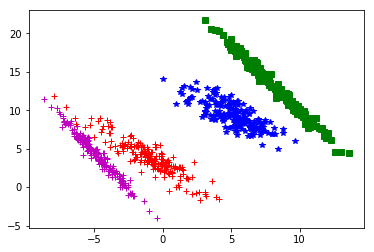

In [7]:
plt.plot(x1,y1,'r+')
plt.plot(x2,y2,'b*')
plt.plot(x3,y3,'gs')
plt.plot(x4,y4,'m+')

**Display the dataset on each worker**

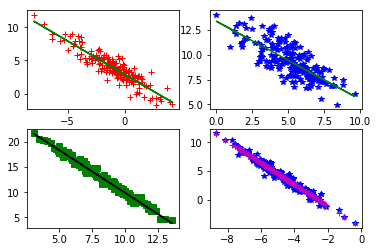

In [8]:
fig, axs = plt.subplots(2, 2)


yhat1=solve_lin_regession(x1,y1)
yhat2=solve_lin_regession(x2,y2)
yhat3=solve_lin_regession(x3,y3)
yhat4=solve_lin_regession(x4,y4)

axs[0][0].plot(x1,y1,'r+')
axs[0][0].plot(x1,yhat1,'g-')

axs[0][1].plot(x2,y2,'b*')
axs[0][1].plot(x2,yhat2,'g-')

axs[1][0].plot(x3,y3,'gs')
axs[1][0].plot(x3,yhat3,'k-')

axs[1][1].plot(x4,y4,'b*')
axs[1][1].plot(x4,yhat4,'m+')


### Distributed Linear Regression

#### Send Data to Workers

In [9]:
len(XY)

4

In [12]:
response = group(lin_regression_tasks.s(json_dump = json.dumps({'XY': seq}, cls=NumpyEncoder)) for seq in XY)() 

In [13]:
message_from_workers=response.get()

In [14]:
response.ready()

True

### Aggregate Results

In [15]:
n_workers = 4
term1_all = 0
for it in range(n_workers):
    term1_all=term1_all+np.asarray(json.loads(message_from_workers[it])["term1"])
print(term1_all)

[[25302.47363892  1455.25433449]
 [ 1455.25433449   800.        ]]


In [16]:
term2_all = 0
for it in range(n_workers):
    term2_all=term2_all + np.asarray(json.loads(message_from_workers[it])["term2"])
print(term2_all)

[[22624.67999337]
 [ 6152.84622013]]


In [17]:
theta_all = np.matmul(np.linalg.inv(term1_all),term2_all)

### Calculate Predictions

In [18]:
x_all=np.vstack([x1,x2,x3,x4])
y_all = np.vstack([y1,y2,y3,y4])
A_all = calc_A(x_all)
yhat_all=np.matmul(A_all,theta_all)


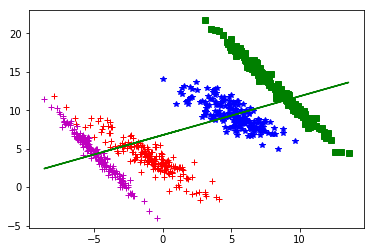

In [19]:
plt.plot(x1,y1,'r+')
plt.plot(x2,y2,'b*')
plt.plot(x3,y3,'gs')
plt.plot(x4,y4,'m+')

plt.plot(x_all,yhat_all,'g-')

### Non-distributed Linear Regression

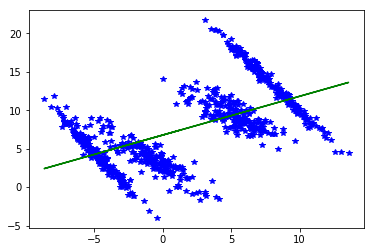

In [23]:
yhat_all=solve_lin_regession(x_all,y_all)

plt.plot(x_all,y_all,'b*')
plt.plot(x_all,yhat_all,'g-')

In [24]:
!sudo rabbitmqctl list_bindings

Listing bindings ...
	exchange	7ecce743-89ec-37cc-a055-c7922744328a	queue	7ecce743-89ec-37cc-a055-c7922744328a	[]
	exchange	celery	queue	celery	[]
	exchange	celery@ip-172-31-34-189.celery.pidbox	queue	celery@ip-172-31-34-189.celery.pidbox	[]
	exchange	celery@ip-172-31-47-170.celery.pidbox	queue	celery@ip-172-31-47-170.celery.pidbox	[]
	exchange	celeryev.99658ebb-8c2b-43e2-b901-e03d1f601680	queue	celeryev.99658ebb-8c2b-43e2-b901-e03d1f601680	[]
	exchange	celeryev.cdb27ee6-001a-46e2-90dc-568eba5f5d1d	queue	celeryev.cdb27ee6-001a-46e2-90dc-568eba5f5d1d	[]
celery	exchange	celery	queue	celery	[]
celery.pidbox	exchange	celery@ip-172-31-34-189.celery.pidbox	queue		[]
celery.pidbox	exchange	celery@ip-172-31-47-170.celery.pidbox	queue		[]
celeryev	exchange	celeryev.99658ebb-8c2b-43e2-b901-e03d1f601680	queue	worker.#	[]
celeryev	exchange	celeryev.cdb27ee6-001a-46e2-90dc-568eba5f5d1d	queue	worker.#	[]


In [12]:
!sudo rabbitmqctl stop_app
!sudo rabbitmqctl reset
!sudo rabbitmqctl start_app

Stopping node 'rabbit@ip-172-31-47-170' ...
Resetting node 'rabbit@ip-172-31-47-170' ...
Starting node 'rabbit@ip-172-31-47-170' ...
